# Backtest: validation on historical data

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/backtest.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>

This notebook contains the simple examples of time series validation using backtest module of ETNA library.

**Table of Contents**

* [What is backtest and how it works](#chapter1)  
* [How to run a validation](#chapter2)
* [Backtest with FoldMask](#chapter3)
* [Validation visualisation](#chapter4)
* [Metrics visualisation](#chapter5)

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

from etna.datasets.tsdataset import TSDataset
from etna.metrics import MAE
from etna.metrics import MSE
from etna.metrics import SMAPE
from etna.pipeline import Pipeline
from etna.models import CatBoostModelMultiSegment
from etna.analysis.plotters import plot_backtest
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.transforms import SegmentEncoderTransform
from etna.transforms import TrendTransform

### 1. What is backtest and how it works <a class="anchor" id="chapter1"></a>

Backtest is a predictions and validation pipeline build on historical data to make a legitimate retrotest of your model.

<b>How does it work?</b>

When constructing a forecast using Models and further evaluating the prediction metrics, we measure the quality at one time interval, designated as test.

Backtest allows you to simulate how the model would work in the past:

* selects a period of time in the past

* builds a model using the selected interval as a training sample

* predicts the value on the test interval and calculates metrics.

The image shows a plot of the backtest pipeline with `n_folds = 3`.

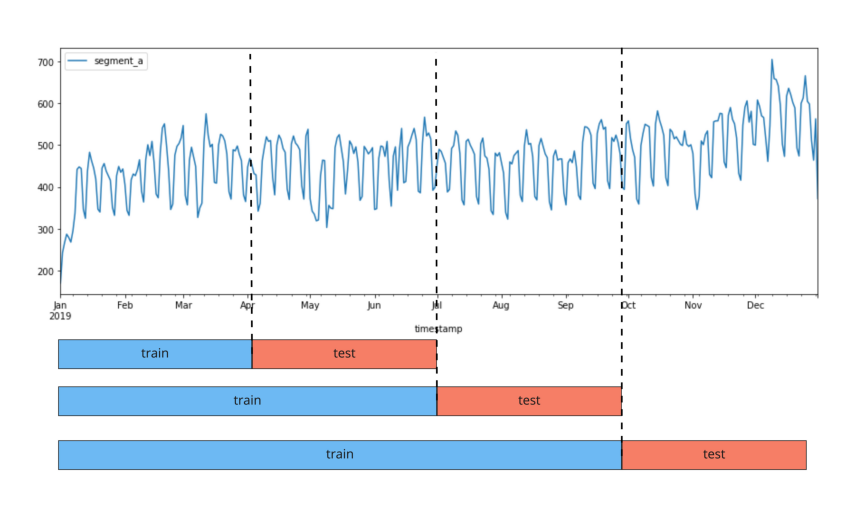

In [51]:
img = plt.imread("./assets/backtest/backtest.jpg")
plt.figure(figsize=(15, 10))
plt.axis("off")
_ = plt.imshow(img)

Below we will call a fold the train + test pair, for which training and forecasting is performed.

In [52]:
df = pd.read_csv("./data/example_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.loc[df.segment == "segment_a"]
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


Our library works with the spacial data structure TSDataset. So, before starting the EDA, we need to convert the classical DataFrame to TSDataset.

In [53]:
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")

#### Let's get a look on series

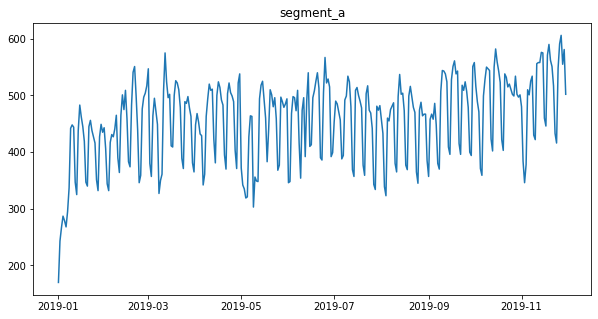

In [54]:
ts.plot(segments=["segment_a"])

### 2. How to run a validation <a class="anchor" id="chapter2"></a>

For an easy start let's create a CatBoost model

In [55]:
horizon = 31  # Set the horizon for predictions
model = CatBoostModelMultiSegment()  # Create a model
transforms = [
    LinearTrendTransform(in_column="target"),
    TrendTransform(in_column="target", out_column="trend"),
    LagTransform(in_column="target", lags=list(range(horizon, horizon + 50)), out_column="target_lag"),
    DateFlagsTransform(
        day_number_in_week=True, day_number_in_month=True, week_number_in_month=True, out_column="date_flag"
    ),
    SegmentEncoderTransform(),
]  # A list of transforms

### `Pipeline` <a class="anchor" id="section_2_1"></a>

Now let's create an instance of `Pipeline`.

In [56]:
pipeline = Pipeline(model=model, transforms=transforms, horizon=horizon)

We are going to run `backtest` method for it. As a result, three dataframes will be returned: 
* dataframe with metrics for each fold and each segment, 
* dataframe with predictions, 
* dataframe with information about folds.

In [57]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.5s finished


In [58]:
metrics_df.head()

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,38.727042,2256.194454,8.694917,0
0,segment_a,20.002736,628.944626,4.617905,1
0,segment_a,19.360927,574.711975,3.994315,2
0,segment_a,22.292272,1003.463761,4.632468,3
0,segment_a,27.229751,1506.113036,5.579908,4


In [59]:
forecast_df.head()

segment                        segment_a                               \
feature    date_flag_day_number_in_month date_flag_day_number_in_week   
timestamp                                                               
2019-06-29                            29                            5   
2019-06-30                            30                            6   
2019-07-01                             1                            0   
2019-07-02                             2                            1   
2019-07-03                             3                            2   

segment                                                                      \
feature    date_flag_is_weekend date_flag_week_number_in_month segment_code   
timestamp                                                                     
2019-06-29                 True                              5            0   
2019-06-30                 True                              5            0   
2019-07-01                False                              1            0   
2019-07-02                False                              1            0   
2019-07-03                False                              1            0   

segment                                                           \
feature         target target_lag_31 target_lag_32 target_lag_33   
timestamp                                                          
2019-06-29  425.490128     11.718785     22.204377     30.689969   
2019-06-30  430.755064     17.233193     11.718785     22.204377   
2019-07-01  490.812905     25.747601     17.233193     11.718785   
2019-07-02  497.381526   -122.737991     25.747601     17.233193   
2019-07-03  463.511122   -121.223583   -122.737991     25.747601   

segment                   ...                                            \
feature    target_lag_34  ... target_lag_73 target_lag_74 target_lag_75   
timestamp                 ...                                             
2019-06-29    -88.824439  ...     67.113651     77.599243     54.084835   
2019-06-30     30.689969  ...     44.628059     67.113651     77.599243   
2019-07-01     22.204377  ...     35.142466     44.628059     67.113651   
2019-07-02     11.718785  ...    -53.343126     35.142466     44.628059   
2019-07-03     17.233193  ...    -78.828718    -53.343126     35.142466   

segment                                                             \
feature    target_lag_76 target_lag_77 target_lag_78 target_lag_79   
timestamp                                                            
2019-06-29    -64.429573    -21.943981     66.541611     65.027203   
2019-06-30     54.084835    -64.429573    -21.943981     66.541611   
2019-07-01     77.599243     54.084835    -64.429573    -21.943981   
2019-07-02     67.113651     77.599243     54.084835    -64.429573   
2019-07-03     44.628059     67.113651     77.599243     54.084835   

segment                                         
feature    target_lag_80     trend fold_number  
timestamp                                       
2019-06-29     76.512795  0.912426           0  
2019-06-30     65.027203  0.998295           0  
2019-07-01     66.541611  1.084165           0  
2019-07-02    -21.943981  1.170034           0  
2019-07-03    -64.429573  1.255904           0  

[5 rows x 58 columns]

In [60]:
fold_info_df.head()

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,2019-01-01,2019-06-28,2019-06-29,2019-07-29,0
0,2019-01-01,2019-07-29,2019-07-30,2019-08-29,1
0,2019-01-01,2019-08-29,2019-08-30,2019-09-29,2
0,2019-01-01,2019-09-29,2019-09-30,2019-10-30,3
0,2019-01-01,2019-10-30,2019-10-31,2019-11-30,4


You can additionally get the metrics averaged over folds:

In [61]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts, metrics=[MAE(), MSE(), SMAPE()], aggregate_metrics=True
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.4s finished


In [62]:
metrics_df.head()

,segment,MAE,MSE,SMAPE
0,segment_a,25.522545,1193.88557,5.503902


In [63]:
forecast_df.head()

segment                        segment_a                               \
feature    date_flag_day_number_in_month date_flag_day_number_in_week   
timestamp                                                               
2019-06-29                            29                            5   
2019-06-30                            30                            6   
2019-07-01                             1                            0   
2019-07-02                             2                            1   
2019-07-03                             3                            2   

segment                                                                      \
feature    date_flag_is_weekend date_flag_week_number_in_month segment_code   
timestamp                                                                     
2019-06-29                 True                              5            0   
2019-06-30                 True                              5            0   
2019-07-01                False                              1            0   
2019-07-02                False                              1            0   
2019-07-03                False                              1            0   

segment                                                           \
feature         target target_lag_31 target_lag_32 target_lag_33   
timestamp                                                          
2019-06-29  425.490128     11.718785     22.204377     30.689969   
2019-06-30  430.755064     17.233193     11.718785     22.204377   
2019-07-01  490.812905     25.747601     17.233193     11.718785   
2019-07-02  497.381526   -122.737991     25.747601     17.233193   
2019-07-03  463.511122   -121.223583   -122.737991     25.747601   

segment                   ...                                            \
feature    target_lag_34  ... target_lag_73 target_lag_74 target_lag_75   
timestamp                 ...                                             
2019-06-29    -88.824439  ...     67.113651     77.599243     54.084835   
2019-06-30     30.689969  ...     44.628059     67.113651     77.599243   
2019-07-01     22.204377  ...     35.142466     44.628059     67.113651   
2019-07-02     11.718785  ...    -53.343126     35.142466     44.628059   
2019-07-03     17.233193  ...    -78.828718    -53.343126     35.142466   

segment                                                             \
feature    target_lag_76 target_lag_77 target_lag_78 target_lag_79   
timestamp                                                            
2019-06-29    -64.429573    -21.943981     66.541611     65.027203   
2019-06-30     54.084835    -64.429573    -21.943981     66.541611   
2019-07-01     77.599243     54.084835    -64.429573    -21.943981   
2019-07-02     67.113651     77.599243     54.084835    -64.429573   
2019-07-03     44.628059     67.113651     77.599243     54.084835   

segment                                         
feature    target_lag_80     trend fold_number  
timestamp                                       
2019-06-29     76.512795  0.912426           0  
2019-06-30     65.027203  0.998295           0  
2019-07-01     66.541611  1.084165           0  
2019-07-02    -21.943981  1.170034           0  
2019-07-03    -64.429573  1.255904           0  

[5 rows x 58 columns]

In [64]:
fold_info_df.head()

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,2019-01-01,2019-06-28,2019-06-29,2019-07-29,0
0,2019-01-01,2019-07-29,2019-07-30,2019-08-29,1
0,2019-01-01,2019-08-29,2019-08-30,2019-09-29,2
0,2019-01-01,2019-09-29,2019-09-30,2019-10-30,3
0,2019-01-01,2019-10-30,2019-10-31,2019-11-30,4


### 3. Backtest with fold masks<a class="anchor" id="chapter3"></a>

You can use your backtest strategies using `FoldMask`. In order to make a `FoldMask`, you need to specify `first_train_timestamp`, `last_train_timestamp`, `target_timestamps`. Then you need to pass a list of masks as the `n_folds` parameter to the `pipeline.backtest`.

Consider 3 strategies similar to `SlidingWindowSplitter`, `ExpandingWindowSplitter` and `SingleWindowSplitter` from `sktime`.

#### `ExpandingWindowSplitter` 

For this backtest strategy you can use our backtest with `mode="expand"`.

In [65]:
metrics_df, _, _ = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=3, mode="expand")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.1s finished


In [66]:
metrics_df

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,19.360927,574.711975,3.994315,0
0,segment_a,22.292272,1003.463761,4.632468,1
0,segment_a,27.229751,1506.113036,5.579908,2


#### `SingleWindowSplitter`

For this backtest strategy you can use our backtest with parameter `n_folds=1` or if you need specific window from your dataset you can create a mask with `FoldMask`.

In [67]:
from etna.pipeline import FoldMask
import numpy as np

In [68]:
# 1 Without mask

metrics_df, _, _ = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=1)
metrics_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s finished


,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,27.229751,1506.113036,5.579908,0


In [69]:
# 2 With specific mask
window_size = 85
first_train_timestamp = ts.index.min() + np.timedelta64(100, "D")
last_train_timestamp = first_train_timestamp + np.timedelta64(window_size, "D")
target_timestamps = pd.date_range(start=last_train_timestamp + np.timedelta64(1, "D"), periods=horizon)
mask = FoldMask(
    first_train_timestamp=first_train_timestamp,
    last_train_timestamp=last_train_timestamp,
    target_timestamps=target_timestamps,
)

In [70]:
# 1 Without mask

metrics_df, _, _ = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=[mask])
metrics_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,49.466842,3927.311305,11.515716,0


#### `SlidingWindowSplitter`

For these backtest strategy you need to create a list of masks with `FoldMask`.

In [71]:
n_folds = 3

In [72]:
def sliding_window_masks(window_size, n_folds):
    masks = []
    for n in range(n_folds):
        first_train_timestamp = ts.index.min() + np.timedelta64(100, "D") + np.timedelta64(n, "D")
        last_train_timestamp = first_train_timestamp + np.timedelta64(window_size, "D")
        target_timestamps = pd.date_range(start=last_train_timestamp + np.timedelta64(1, "D"), periods=horizon)
        mask = FoldMask(
            first_train_timestamp=first_train_timestamp,
            last_train_timestamp=last_train_timestamp,
            target_timestamps=target_timestamps,
        )
        masks.append(mask)
    return masks

In [73]:
masks = sliding_window_masks(window_size=window_size, n_folds=n_folds)
metrics_df, _, _ = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=masks)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s finished


In [74]:
metrics_df

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,49.466842,3927.311305,11.515716,0
0,segment_a,45.590567,3388.522058,10.624427,1
0,segment_a,45.152959,3011.989936,10.476108,2


### 4. Validation visualisation <a class="anchor" id="chapter4"></a>

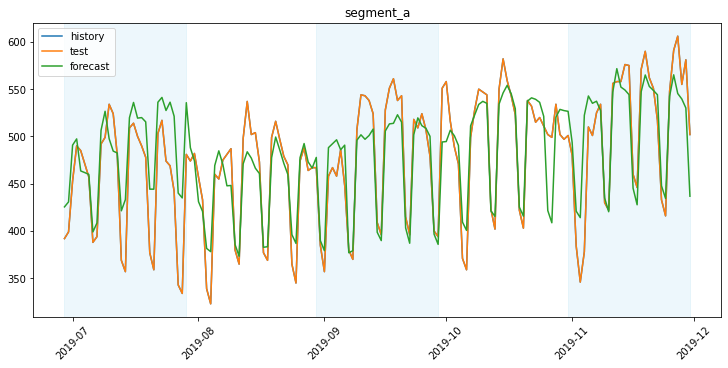

In [75]:
plot_backtest(forecast_df, ts)

Let's see how the data looked before the backtest -  we specify `history_len`.

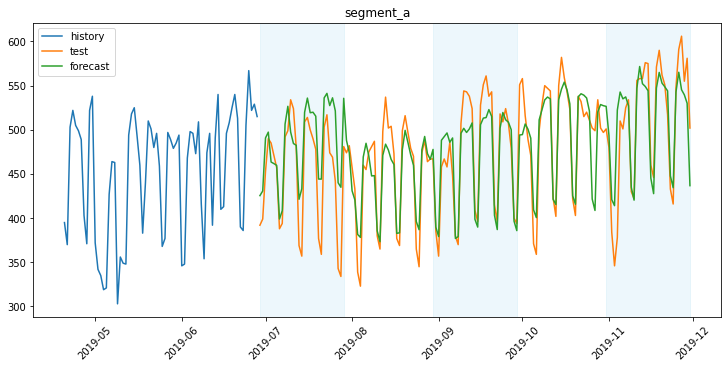

In [76]:
plot_backtest(forecast_df, ts, history_len=70)

### 5. Metrics visualization  <a class="anchor" id="chapter5"></a>

In this section we will analyze the backtest results from the different point of views. 

In [77]:
from etna.analysis import (
    metric_per_segment_distribution_plot,
    plot_residuals,
    plot_metric_per_segment,
    prediction_actual_scatter_plot,
)

In [78]:
df = pd.read_csv("./data/example_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = TSDataset.to_dataset(df)
ts_all = TSDataset(df, freq="D")

In [79]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts_all, metrics=[MAE(), MSE(), SMAPE()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   23.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.9s finished


Let's look at the distribution of the SMAPE metric by folds. You can set `type_plot` as `box`, `violin` or `hist`.

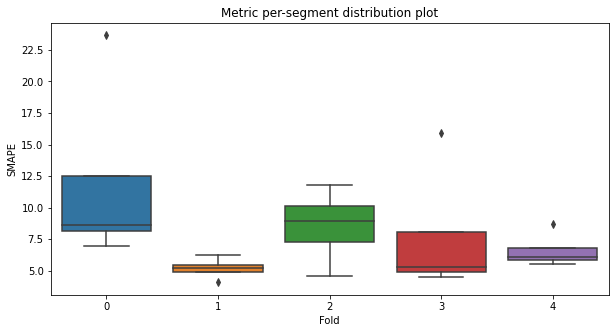

In [80]:
metric_per_segment_distribution_plot(metrics_df=metrics_df, metric_name="SMAPE", plot_type="box")

Let's look at the SMAPE metric by segments

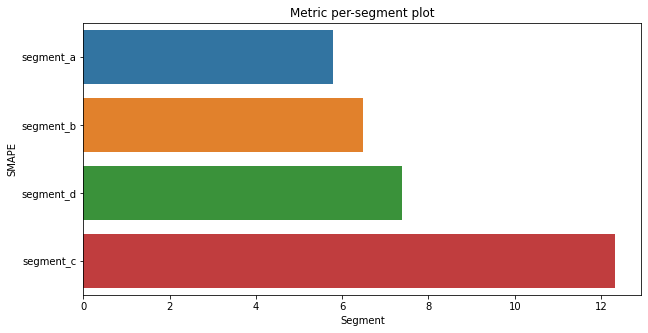

In [81]:
plot_metric_per_segment(metrics_df=metrics_df, metric_name="SMAPE", ascending=True)

Now let's look at the residuals of the model predictions from the backtest. Analysis of the residuals can help establish a dependency in the data that our model was not able to find. This way we can add features or improve the model or make sure that there is no dependency in the residuals. Also, you can visualize the residuals not only by timestamp but by any feature.

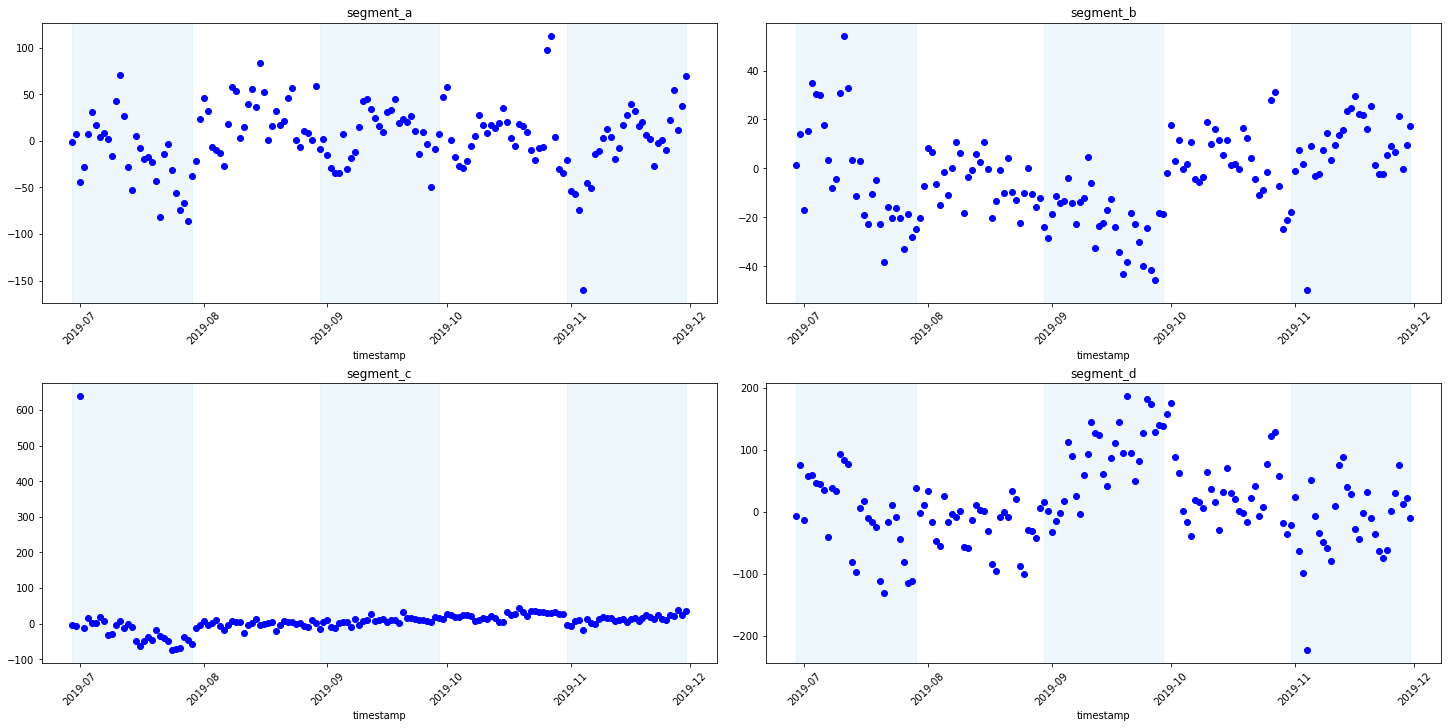

In [82]:
plot_residuals(forecast_df=forecast_df, ts=ts_all)

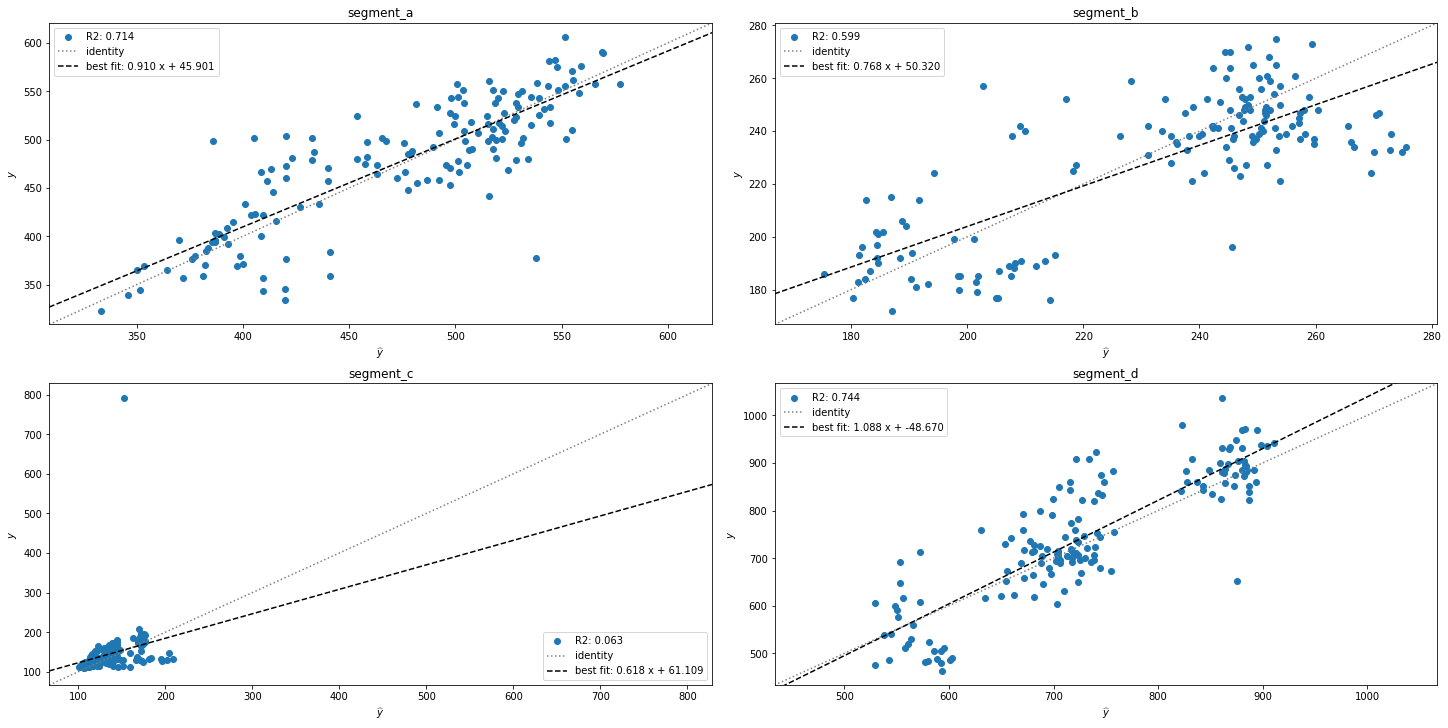

In [83]:
prediction_actual_scatter_plot(forecast_df=forecast_df, ts=ts_all)

That's all for this notebook. More features you can find in our documentation!